In [1526]:

import numpy as np
# import matplotlib.pyplot as plt
# import plotly.express as px
import plotly.graph_objects as go

In [1527]:
N = 100000
n_stations = 150

In [1528]:
np.random.seed(42)

In [1529]:
stations = np.random.uniform(low= 0, high=N, size=(n_stations, 2))


In [1530]:
plane_route = np.array([[x,int(0.3 * x)] for x in range(0,int(N/2),1000 )] + [[x, x - int(0.7 * N/2)] for x in range(int(N/2),N+1,1000 )])

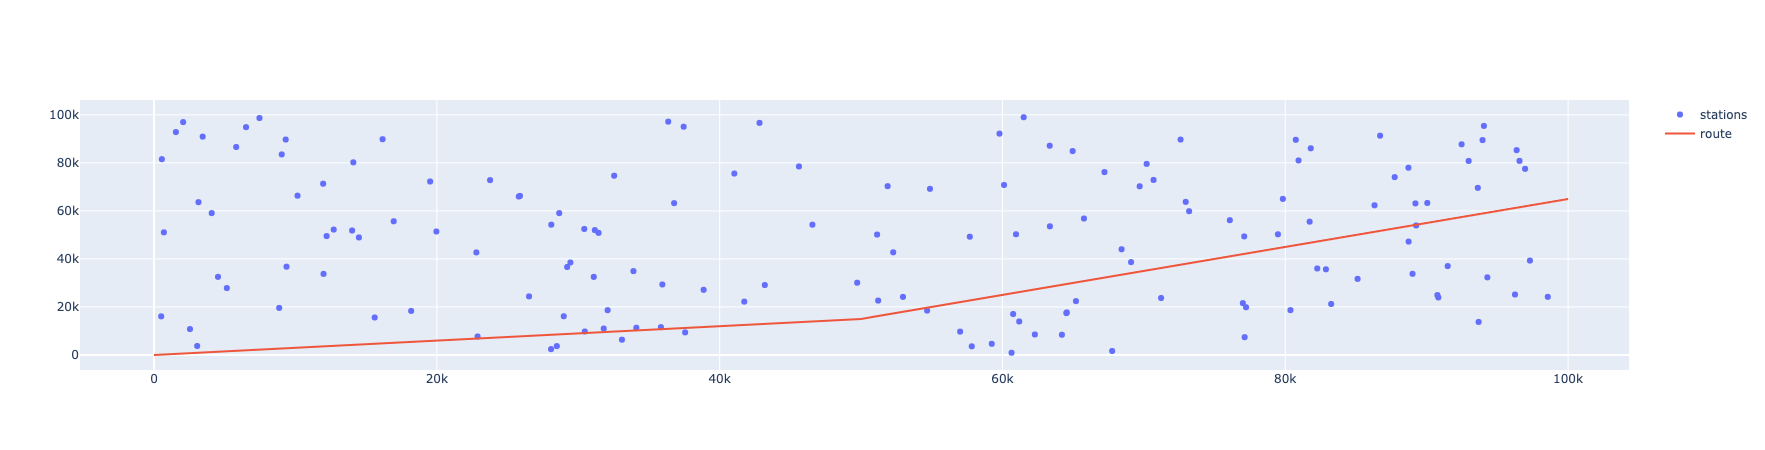

In [1531]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=stations[:,0], y=stations[:,1],
                    mode='markers',
                    name='stations'))
fig.add_trace(go.Scatter(x=plane_route[:,0], y=plane_route[:,1],
                    mode='lines',
                    name='route'))


In [1532]:
def find_closest_point(point, stations):
    d = np.linalg.norm(stations - point, axis=1)
    return np.argmin(d)

In [1533]:
def closest_path(route, stations):
    res = [stations[find_closest_point(p, stations), :] for p in route]
    return res


In [1534]:
path_long = np.array(closest_path(plane_route, stations))
path = np.unique(path_long, axis=0)

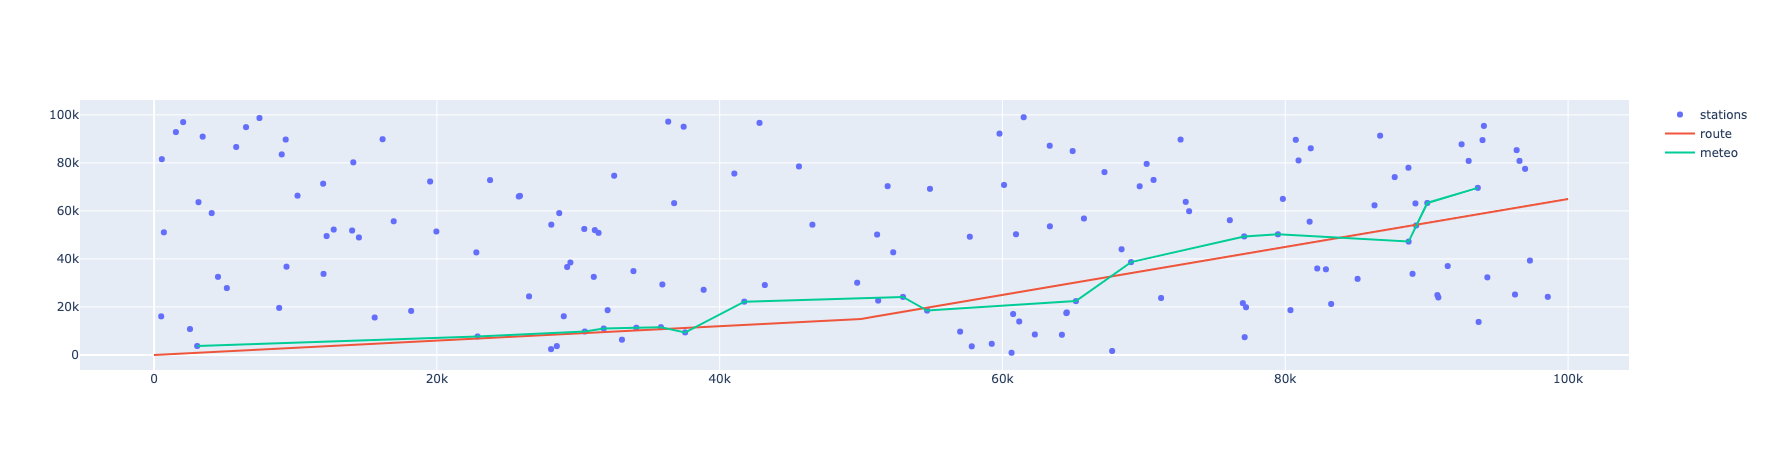

In [1535]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=stations[:,0], y=stations[:,1],
                    mode='markers',
                    name='stations'))
fig.add_trace(go.Scatter(x=plane_route[:,0], y=plane_route[:,1],
                    mode='lines',
                    name='route'))
fig.add_trace(go.Scatter(x=path[:,0], y=path[:,1],
                    mode='lines',
                    name='meteo'))

In [1536]:
from scipy.spatial.distance import cosine


In [1537]:
def compute_penalty(path):
    return sum([cosine(path[i+1]-path[i], path[i]- path[i-1]) for i in range(1,len(path)-1)])

In [1538]:
def compute_distances(path, route):
    return np.array([np.linalg.norm(path-r,axis=1)**2 for r in route])


In [1539]:
distances = compute_distances(path, plane_route)

In [1540]:
distance_dict = {i:min(distances[:, i]) for i in range(len(path))}

In [1541]:
def l2_loss(distances, indices):
    dd = distances[:, indices]
    return sum(dd.min(axis=1))


In [1542]:
def global_loss(path, route, distances, indices, l):
    return (np.log(l2_loss(distances, indices)) + l*compute_penalty(path[indices]))/len(indices)


In [1543]:
from itertools import combinations
from tqdm import tqdm

In [1544]:
def find_opt_path(path, plane_route, distances, min_points_to_remove, max_points_to_remove, l):
    best_loss = global_loss(path, plane_route, distances, [i for i in range(len(path))], l )

    min_loss_path = path
    for k in tqdm(range(min_points_to_remove+1)):
        min_loss = N
        current_path = min_loss_path
        if len(current_path) <= len(path) - min_points_to_remove:
            break
        for p in combinations(range(1,len(current_path)-1), k):
            indices = [i for i in range(len(current_path)) if i not in p]
            new_loss = global_loss(current_path, plane_route, distances, indices, l)
            if new_loss < min_loss:
                min_loss = new_loss
                min_loss_path = current_path[indices]


    losses = [best_loss]
    current_path = min_loss_path
    best_path = min_loss_path
    print("length after min_removal", len(current_path))
    for k in tqdm(range(max_points_to_remove-min_points_to_remove+1)):
        for p in combinations(range(1,len(current_path)-1), k):
            indices = [i for i in range(len(current_path)) if i not in p]
            new_loss = global_loss(current_path, plane_route, distances, indices, l)
            if new_loss < best_loss:
                best_loss = new_loss
                losses.append(new_loss)
                best_path = current_path[indices]
    print("length after optimization", len(best_path))
    return best_path, losses

In [1545]:
def plot_res(stations, plane_route, path, best_paths):
    fig = go.Figure()

    # Add traces
    fig.add_trace(go.Scatter(x=stations[:,0], y=stations[:,1],
                        mode='markers',
                        name='stations'))
    fig.add_trace(go.Scatter(x=plane_route[:,0], y=plane_route[:,1],
                        mode='lines',
                        name='route'))
    fig.add_trace(go.Scatter(x=path[:,0], y=path[:,1],
                    mode='lines',
                    name='meteo'))
    for i, best_path in enumerate(best_paths):
        fig.add_trace(go.Scatter(x=best_path[:,0], y=best_path[:,1],
                            mode='lines',
                            name='meteo_opt_' + str(i)))
    return fig

In [1546]:
min_points_to_remove = 5
max_points_to_remove = 8
best_paths = []
print("Meteo route length:", len(path))
for l in [0.1, 1, 10]:
    opt_path = find_opt_path(path, plane_route, distances, min_points_to_remove, max_points_to_remove, l)
    best_paths.append(opt_path[0])
    print(len(best_paths[-1]), opt_path[1])

100%|██████████| 4/4 [00:00<00:00, 96.81it/s]


Meteo route length: 18
length after min_removal 12
length after optimization 12
12 [1.2472146705880092]
length after min_removal 12
length after optimization 12
12 [1.5999008113714843]
length after min_removal 12
length after optimization 12
12 [5.1267622192062365, 2.577508334460582]


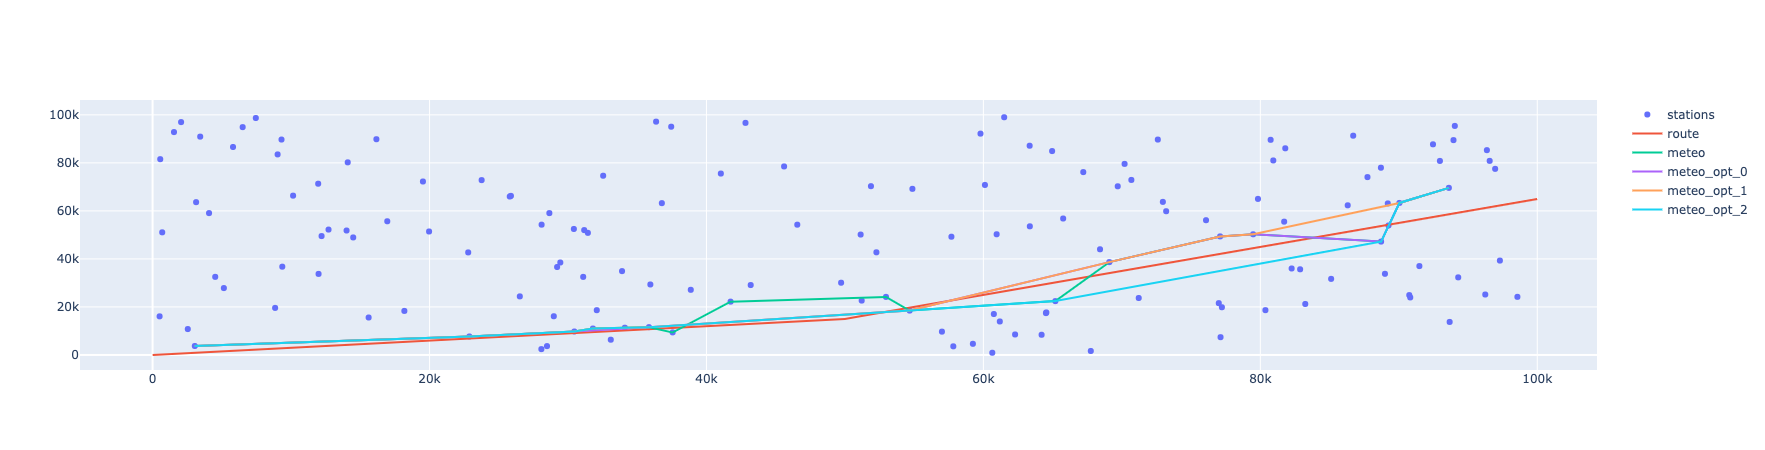

In [1547]:
plot_res(stations, plane_route, path, best_paths)
